In [1]:
import pyzed.sl as sl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
svo_path = '../../data/HD1080_SN35520970_11-03-24.svo'

In [8]:
zed = sl.Camera()

# init parameters
init_params = sl.InitParameters()
init_params.set_from_svo_file(svo_path)
init_params.depth_mode = sl.DEPTH_MODE.ULTRA
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_maximum_distance = 40
init_params.depth_minimum_distance = 1
init_params.sdk_verbose = True

zed.open(init_params)

SUCCESS

In [6]:
calibration_frames = 120
skip_frames = 30

In [10]:
runtime_parameters = sl.RuntimeParameters()
temp_image_left = sl.Mat()
temp_image_right = sl.Mat()
temp_image_depth_left = sl.Mat()

In [11]:
color_array_l = np.zeros((1080, 1920, 3, calibration_frames))
color_array_r = np.zeros((1080, 1920, 3, calibration_frames))
depth_array_l = np.zeros((1080, 1920, calibration_frames))

In [12]:
for i in tqdm(range(calibration_frames * skip_frames)):
    zed.grab(runtime_parameters)
    if i % skip_frames != 0:
        continue
    # zed.retrieve_measure(image, sl.MEASURE.DEPTH)
    zed.retrieve_image(temp_image_left, sl.VIEW.LEFT)
    current_frame_l = temp_image_left.get_data()[:, :, :3]
    color_array_l[:, :, :, i // skip_frames] = current_frame_l
    
    zed.retrieve_measure(temp_image_depth_left, sl.MEASURE.DEPTH)
    current_frame_depth_l = temp_image_depth_left.get_data()[:,:]
    depth_array_l[:,:,i // skip_frames] = current_frame_depth_l

100%|██████████| 3600/3600 [01:13<00:00, 48.90it/s]


In [14]:
# get median depth
median_depth_l = np.nanmedian(color_array_l, axis=3)
np.save('median_background_l.npy', median_depth_l)

In [15]:
depth_array_nan_l = np.where(np.isinf(depth_array_l), 45, depth_array_l)
depth_array_nan_l = np.where(np.isnan(depth_array_nan_l), 0, depth_array_nan_l)

In [16]:
depth_background_l = np.nanmedian(depth_array_nan_l, axis=2)
np.save('depth_background_l.npy', depth_background_l)

In [17]:
print(f'Background: {median_depth_l.shape}')
print(f'Depth Background: {depth_background_l.shape}')

Background: (1080, 1920, 3)
Depth Background: (1080, 1920)


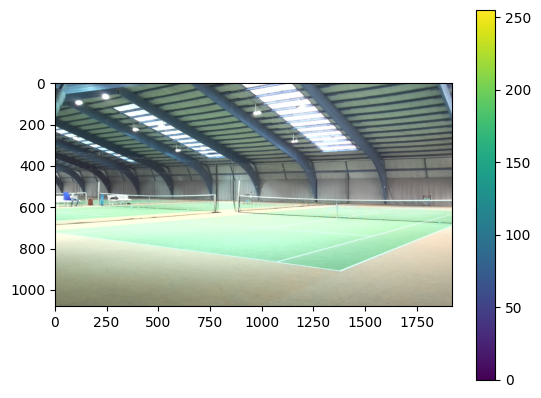

In [18]:
plt.imshow(median_depth_l.astype(np.uint8))
plt.colorbar()
plt.show()

(1080, 1920)


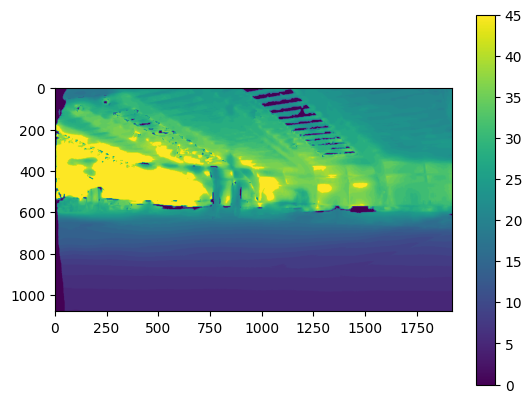

In [19]:
print(depth_background_l.shape)
plt.imshow(depth_background_l.astype(np.uint8))
plt.colorbar()
plt.show()

In [20]:
image_left = sl.Mat()
image_right = sl.Mat()
depth = sl.Mat()

In [21]:
# init detection parameters
detection_parameters = sl.ObjectDetectionParameters()

detection_parameters.image_sync = True
detection_parameters.enable_tracking = True
detection_parameters.enable_segmentation = True

detection_parameters.detection_model = sl.OBJECT_DETECTION_MODEL.MULTI_CLASS_BOX_MEDIUM

if detection_parameters.enable_tracking:
    zed.enable_positional_tracking()

zed.enable_object_detection(detection_parameters)

detection_confidence = 20
detection_parameters_rt = sl.ObjectDetectionRuntimeParameters(detection_confidence)

detection_parameters_rt.object_class_filter = [sl.OBJECT_CLASS.PERSON, sl.OBJECT_CLASS.SPORT]

detected_objects = sl.Objects()
runtime_parameters = sl.RuntimeParameters()

In [22]:
zed.set_svo_position(200)
zed.grab(runtime_parameters)
zed.retrieve_objects(detected_objects, detection_parameters_rt)
detected_objects.object_list

In [2]:
def convert_BGR_to_RGB(image):
    imageBlue = image[:,:, 0]
    imageGreen = image[:,:, 1]
    imageRed = image[:,:, 2]
    newRGBImage = np.zeros_like(image)
    newRGBImage[:,:,0] = imageRed
    newRGBImage[:,:,1] = imageGreen
    newRGBImage[:,:,2] = imageBlue
    
    returnImage = newRGBImage.astype(np.uint8)
    return returnImage

In [3]:
#Get Area of Interest betweeen two persons
def get_area_of_interest(image):
    mask = np.zeros_like(image)

    tiefstePersonSum = np.inf
    tiefstePersonLocation = [1080, 1920]
    höchstePersonSum = 0
    höchstePersonLocation = [0, 0]
    
    # get the bounding box
    for person in detected_objects.object_list:
        if person.label == sl.OBJECT_CLASS.PERSON:
            bb = person.bounding_box_2d
            for i in range(len(bb)):
                koordinateSum = bb[i][0] + bb[i][1]
                if koordinateSum > höchstePersonSum:
                    höchstePersonSum = koordinateSum
                    höchstePersonLocation = bb[i]
                if koordinateSum < tiefstePersonSum:
                    tiefstePersonSum = koordinateSum
                    tiefstePersonLocation = bb[i]

    
    
    
    # extend the bounding box by 10 pixels
    tiefstePersonLocation[0] -= 100
    tiefstePersonLocation[1] -= 100
    höchstePersonLocation[0] += 100
    höchstePersonLocation[1] += 100

    mask[int(tiefstePersonLocation[1]):int(höchstePersonLocation[1]), int(tiefstePersonLocation[0]):int(höchstePersonLocation[0])] = 1
    
    return mask  

In [4]:
def find_yellow_areas(image):
    
    ### ACHTUNG: Die Matrix der ZED-Library gibt BGR-Bilder aus und keine RGB. [BlauMin, GrünMin, RotMin), (BlauMax, GrünMax, RotMax)] ###
    # Definieren der Gelbschwelle
    yellow_threshold = [(0, 180, 180), (200, 255, 255)]  # Min und Max für Gelb

    binary_matrix = np.zeros((image.shape[0], image.shape[1]))

    # Finden der Pixel, die innerhalb des Gelb-Bereichs liegen
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel = image[i, j, :]
            if (pixel[0] > yellow_threshold[0][0] and pixel[0] < yellow_threshold[1][0]) and \
               (pixel[1] > yellow_threshold[0][1] and pixel[1] < yellow_threshold[1][1]) and \
               (pixel[2] > yellow_threshold[0][2] and pixel[2] < yellow_threshold[1][2]):
                binary_matrix[i, j] = 1

    return binary_matrix

In [5]:
def sliding_window(image, window_size):
    """
    Bewegt ein gleitendes Fenster über das Bild und berechnet die Summe der Pixelwerte in jedem Fenster.

    :param image: Das 2D-Array, das das Bild repräsentiert.
    :param window_size: Eine Tuple (height, width), die die Größe des Fensters angibt.
    :return: Ein 2D-Array mit den Summen der Pixelwerte in jedem Fenster.
    """
    # Bildgröße ermitteln
    image_height, image_width = image.shape

    # Fenstergröße ermitteln
    window_height, window_width = window_size

    # Ausgabearray erstellen
    output_height = image_height - window_height + 1
    output_width = image_width - window_width + 1
    output = np.ones(image.shape)

    # Durch das Bild iterieren
    for i in range(output_height):
        for j in range(output_width):
            # Fensterbereich auswählen
            window = image[i:i + window_height, j:j + window_width]
            
            # Berechnung durchführen (hier: Summe der Pixelwerte)
            window_sum = np.sum(window)
            
            # Ergebnis im Ausgabearray speichern
            output[i, j] = window_sum

    return output

In [6]:
# create a mask for the detected object
def get_mask(index, image):
    mask = np.zeros_like(image)

    # get the bounding box
    bb = detected_objects.object_list[index].bounding_box_2d

    # extend the bounding box by 10 pixels
    bb[0, :] -= 30
    bb[1, :] += 30
    bb[2, :] += 30
    bb[3, :] -= 30

    # get the mask
    mask[int(bb[0, 1]):int(bb[2, 1]), int(bb[0, 0]):int(bb[1, 0])] = 1

    
    return mask

In [7]:
from scipy.ndimage import maximum_position, uniform_filter, binary_dilation
def detect_tennis_ball(moving_pixels, depth_pixels, detected_objects):
    f, ax = plt.subplots()
    f.set_size_inches(15, 15)
    
    plt.subplot(3, 2, 1)
    plt.imshow((1 - np.isnan(depth_pixels.numpy())))
    plt.title('depth_pixels')
    
    diff_pixels = np.square(moving_pixels.astype(np.uint8)).sum(axis=2)
    
    plt.subplot(3, 2, 2)
    plt.imshow(diff_pixels)
    plt.title('diff pixels')
    
    diff_normalized = (diff_pixels / diff_pixels.max()).round()
    
    plt.subplot(3, 2, 3)
    plt.imshow(diff_normalized)
    plt.title('diff normalized')
    
    masked = diff_normalized
    for i in range(len(detected_objects.object_list)):
        mask = get_mask(i, diff_normalized)
        masked = masked - mask
    
    masked = masked - (1 - np.isnan(depth_pixels.numpy()))
    
    plt.subplot(3, 2, 4)
    plt.imshow(masked)
    plt.title('masked')
    
    masked[masked < 0] = 0
        
    plt.subplot(3, 2, 5)
    plt.imshow(masked)
    plt.title('masked')
    
    # set 100 pixels from border to 0
    masked[:100, :] = 0
    masked[-100:, :] = 0
    masked[:, :100] = 0
    masked[:, -100:] = 0
    
    dilated = binary_dilation(masked, iterations=1)
    
    plt.subplot(3, 2, 6)
    plt.imshow(dilated)
    plt.title('dilated')
    
    #filtered = uniform_filter(dilated, size=4)
    
    #plt.subplot(3, 2, 6)
    #plt.imshow(filtered)
    #plt.title('filtered')
    plt.show()
    
    return maximum_position(dilated)

In [8]:
from scipy.ndimage import maximum_position, binary_dilation

def detect_tennis_ball_dsa(moving_pixels, moving_depth, detected_objects, original_picture):
    
    diff_pixels = np.square(moving_pixels.astype(np.uint8)).sum(axis=2)
 
    areaOfInterest = get_area_of_interest(diff_pixels)
    filteredByInterest = diff_pixels * areaOfInterest
    
    minPixelStrength = int(filteredByInterest.max()*0.7)
    diff_pixels_dsa = filteredByInterest.copy()
    diff_pixels_dsa[diff_pixels_dsa < minPixelStrength] = 0
       
    masked = diff_pixels_dsa.copy()
    for i in range(len(detected_objects.object_list)):
        mask = get_mask(i, diff_pixels_dsa)
        masked[mask == 1.0] = 0.0
    
    yellow_areas = find_yellow_areas(original_picture)
    yellow_areas = yellow_areas * masked

    
    windows = sliding_window(yellow_areas, (7, 7))

    tennisballs = np.unravel_index(np.argsort(windows, axis=None)[::-1], windows.shape)
    #return list(zip(tennisballs[0], tennisballs[1]))
    return [tennisballs[0][0], tennisballs[1][0]]

In [9]:
# draw the bounding box 10 pixels around the center
def draw_bb(image, center):
    bb = np.zeros_like(image)
    bb[center[0] - 15:center[0] + 15, center[1] - 15:center[1] + 15] = 255
    # add blue and green channel
    #bb[:, :, 1] = np.zeros_like(bb[:, :, 0])
    #bb[:, :, 2] = bb[:, :, 1]
    return bb

In [31]:
zed.close()

import pyzed.sl as sl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

svo_path = './data/HD1080_SN35520970_11-03-24.svo'
zed = sl.Camera()

# init parameters
init_params = sl.InitParameters()
init_params.set_from_svo_file(svo_path)
init_params.depth_mode = sl.DEPTH_MODE.ULTRA
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_maximum_distance = 40
init_params.depth_minimum_distance = 1
init_params.sdk_verbose = True

zed.open(init_params)

current_frame_left = sl.Mat()
current_frame_right = sl.Mat()
current_frame_depth_left = sl.Mat()
current_frame_depth_right = sl.Mat()
detected_objects = sl.Objects()

# init detection parameters
detection_parameters = sl.ObjectDetectionParameters()

detection_parameters.image_sync = True
detection_parameters.enable_tracking = True
detection_parameters.enable_segmentation = True

detection_parameters.detection_model = sl.OBJECT_DETECTION_MODEL.MULTI_CLASS_BOX_MEDIUM

if detection_parameters.enable_tracking:
    zed.enable_positional_tracking()

zed.enable_object_detection(detection_parameters)

detection_confidence = 10
detection_parameters_rt = sl.ObjectDetectionRuntimeParameters(detection_confidence)

detection_parameters_rt.object_class_filter = [sl.OBJECT_CLASS.PERSON, sl.OBJECT_CLASS.SPORT]

detected_objects = sl.Objects()
runtime_parameters = sl.RuntimeParameters()



zed.set_svo_position(6880)
print("Current frame: ", zed.get_svo_position())

# Grab an image
if zed.grab(runtime_parameters) == sl.ERROR_CODE.SUCCESS:
    zed.retrieve_image(current_frame_left, sl.VIEW.LEFT)
    zed.retrieve_measure(current_frame_depth_left, sl.MEASURE.DEPTH)
    zed.retrieve_image(current_frame_right,sl.VIEW.RIGHT)
    #zed.retrieve_image(current_frame_depth_right, sl.VIEW.DEPTH_RIGHT)
    zed.retrieve_objects(detected_objects, detection_parameters_rt)

Current frame:  6880


In [32]:

current_frame_left_data = current_frame_left.get_data()[:, :, :3]
current_frame_depth_l_data = current_frame_depth_left.get_data()[:,:]
current_frame_right_data = current_frame_right.get_data()[:, :]
#current_frame_depth_r_data = current_frame_depth_right.get_data()[:,:,:]


In [33]:
detected_objects.object_list

In [34]:
moving_left = current_frame_left_data - median_depth_l
moving_depth = current_frame_depth_l_data - depth_background_l
moving_depth = np.square(moving_depth.astype(np.uint8))
#moving_right = current_frame_left_data - median_depth_r

C:\Users\denis\AppData\Local\Temp\ipykernel_10536\3412764444.py:3: RuntimeWarning: invalid value encountered in cast
  moving_depth = np.square(moving_depth.astype(np.uint8))


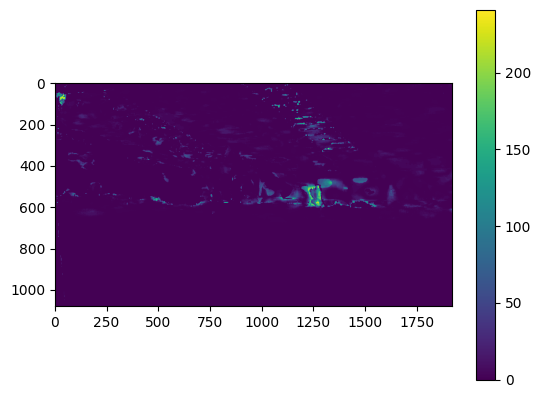

In [35]:
plt.imshow(moving_depth)
plt.colorbar()
plt.show()

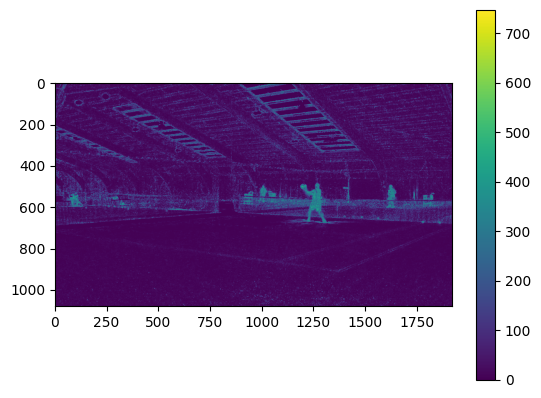

In [36]:
plt.imshow(np.square(moving_left.astype(np.uint8)).sum(axis=2))
plt.colorbar()
plt.show()

In [37]:
tennis_ball_pos = detect_tennis_ball_dsa(moving_left, moving_depth, detected_objects, current_frame_left_data)

In [38]:
print(tennis_ball_pos[:1000])

[538, 921]


In [39]:
tennis_ball_bb = draw_bb(current_frame_left_data, tennis_ball_pos)

In [40]:
frame_with_bb = tennis_ball_bb.copy()
frame_with_bb[tennis_ball_bb != 255] = current_frame_left_data[tennis_ball_bb != 255]

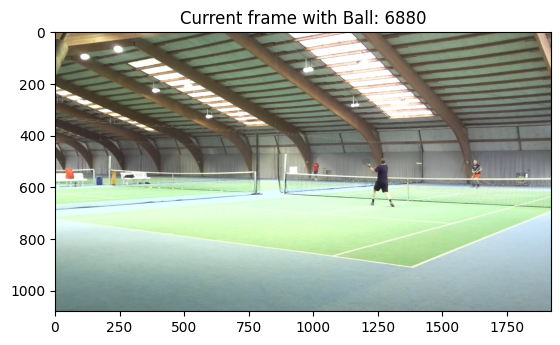

In [41]:
plt.imshow(convert_BGR_to_RGB(frame_with_bb))
plt.title(f'Current frame with Ball: {zed.get_svo_position()}')
plt.show()

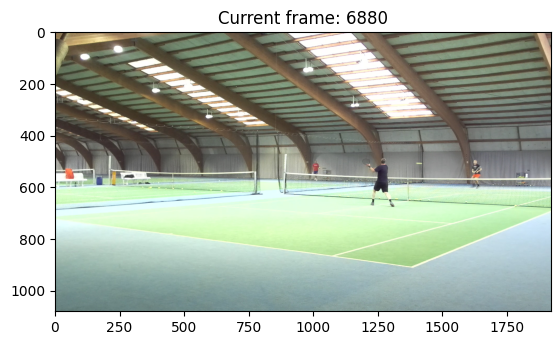

In [42]:
plt.imshow(convert_BGR_to_RGB(current_frame_left_data))
plt.title(f'Current frame: {zed.get_svo_position()}')
plt.show()

**For-Loop für mehrere Frames**

In [54]:
zed.close()

In [55]:

import pyzed.sl as sl
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


framerange = (500, 750)

svo_path = './data/HD1080_SN35520970_11-03-24.svo'
zed = sl.Camera()
video = np.zeros((1080, 1920, 3, framerange[1] - framerange[0]))

# init parameters
init_params = sl.InitParameters()
init_params.set_from_svo_file(svo_path)
init_params.depth_mode = sl.DEPTH_MODE.ULTRA
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_maximum_distance = 40
init_params.depth_minimum_distance = 1
init_params.sdk_verbose = True

zed.open(init_params)

current_frame_left = sl.Mat()
current_frame_right = sl.Mat()
current_frame_depth_left = sl.Mat()
current_frame_depth_right = sl.Mat()
detected_objects = sl.Objects()

# init detection parameters
detection_parameters = sl.ObjectDetectionParameters()

detection_parameters.image_sync = True
detection_parameters.enable_tracking = True
detection_parameters.enable_segmentation = True

detection_parameters.detection_model = sl.OBJECT_DETECTION_MODEL.MULTI_CLASS_BOX_MEDIUM

if detection_parameters.enable_tracking:
    zed.enable_positional_tracking()

zed.enable_object_detection(detection_parameters)

detection_confidence = 10
detection_parameters_rt = sl.ObjectDetectionRuntimeParameters(detection_confidence)

detection_parameters_rt.object_class_filter = [sl.OBJECT_CLASS.PERSON, sl.OBJECT_CLASS.SPORT]

detected_objects = sl.Objects()
runtime_parameters = sl.RuntimeParameters()
loaded_median_depth_l = np.load('median_background_l.npy')
loaded_depth_background_l = np.load('depth_background_l.npy')

for frame in tqdm(range(framerange[0], framerange[1])):
    zed.set_svo_position(frame)

    if zed.grab(runtime_parameters) == sl.ERROR_CODE.SUCCESS:
        #Get Images
        zed.retrieve_image(current_frame_left, sl.VIEW.LEFT)
        zed.retrieve_measure(current_frame_depth_left, sl.MEASURE.DEPTH)
        #zed.retrieve_image(current_frame_right,sl.VIEW.RIGHT)
        #zed.retrieve_image(current_frame_depth_right, sl.VIEW.DEPTH_RIGHT)
        zed.retrieve_objects(detected_objects, detection_parameters_rt)
        
        #Get Arrays
        current_frame_left_data = current_frame_left.get_data()[:, :, :3]
        current_frame_depth_l_data = current_frame_depth_left.get_data()[:,:]
        
        #Get Moving Pixels
        moving_left = current_frame_left_data - loaded_median_depth_l
        moving_depth = current_frame_depth_l_data - loaded_depth_background_l
        moving_depth = np.where(np.isnan(moving_depth), 0, moving_depth)
        moving_depth = np.where(np.isinf(moving_depth), 0, moving_depth)
        moving_depth = np.square(moving_depth).astype(np.uint8)
        
        #Get Tennis Ball Position
        tennis_ball_pos = detect_tennis_ball_dsa(moving_left, moving_depth, detected_objects, current_frame_left_data)

        tennis_ball_bb = draw_bb(current_frame_left_data, tennis_ball_pos)
        frame_with_bb = tennis_ball_bb.copy()
        frame_with_bb[tennis_ball_bb != 255] = current_frame_left_data[tennis_ball_bb != 255]
        video[:, :, :, frame - framerange[0]] = frame_with_bb

100%|██████████| 250/250 [59:31<00:00, 14.29s/it]


In [62]:
from datetime import datetime
datestring = datetime.now().strftime("%Y-%m-%d-%H-%M")
filename = f'video-{datestring}-Raw.npy'
np.save(filename, video)

In [56]:
import cv2
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
video_komplett = cv2.VideoWriter('output.mp4', fourcc, 20, (1920, 1080))  # Bildrate und Auflösung

# Bilder zum Video hinzufügen

for bild in range(video.shape[3]):
    video_komplett.write(video[:, :, :, bild].astype(np.uint8))

# Video speichern
video_komplett.release()

In [30]:
np.min(video)

0.0

In [1]:
from helperClasses.tennis_ball_detection import BallDetection

svo_path = '../../data/HD1080_SN35520970_11-03-24.svo'
ballDetection = BallDetection(svo_path)

ballDetection.load_background('./median_background_l.npy')

ballDetection.get_ball_by_frame(500, 1100, True)

100%|██████████| 600/600 [28:32<00:00,  2.85s/it] 


array([[[[ 74.,  71.,  75., ...,  72.,  71.,  74.],
         [101.,  97.,  99., ...,  98.,  98., 100.],
         [125., 121., 123., ..., 121., 122., 124.]],

        [[ 74.,  74.,  75., ...,  72.,  70.,  72.],
         [101., 100.,  99., ..., 101.,  97.,  98.],
         [125., 124., 123., ..., 121., 121., 122.]],

        [[ 75.,  73.,  76., ...,  71.,  73.,  76.],
         [ 99.,  99., 100., ...,  97., 100., 102.],
         [123., 123., 124., ..., 120., 124., 126.]],

        ...,

        [[148., 154., 147., ..., 142., 141., 144.],
         [156., 162., 154., ..., 156., 156., 157.],
         [160., 166., 158., ..., 154., 154., 155.]],

        [[147., 148., 147., ..., 142., 141., 143.],
         [156., 159., 154., ..., 156., 155., 158.],
         [158., 162., 157., ..., 154., 153., 155.]],

        [[147., 143., 147., ..., 143., 143., 145.],
         [158., 154., 156., ..., 157., 157., 159.],
         [163., 158., 159., ..., 155., 155., 159.]]],


       [[[ 70.,  74.,  73., ...,  67